In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import stats

from tqdm import tqdm
import pickle

In [2]:
#preds, targets, weights (sorted by preds)
with open("./alldata_3_sources.pkl", 'rb') as fin:
    mhc1, mhc1a, mhc2a = pickle.load(fin)

In [3]:
with open("./cali1.pkl", 'rb') as fin:
    it1, loss1 = pickle.load(fin)
with open("./cali1a.pkl", 'rb') as fin:
    it1a, loss1a = pickle.load(fin)
with open("./cali2a.pkl", 'rb') as fin:
    it2a, loss2a = pickle.load(fin)
with open("./calicurve32_100k.pkl", 'rb') as fin:
    (it1, loss1), (it1a, loss1a), (it2a, loss2a) = pickle.load(fin)
with open("./calicurve32_200k_1a.pkl", 'rb') as fin:
    (it1a, loss1b) = pickle.load(fin)
    loss1a = np.concatenate((loss1a, loss1b))
with open("./calicurve32_200k_2a.pkl", 'rb') as fin:
    (it2a, loss2b) = pickle.load(fin)
    loss2a = np.concatenate((loss2a, loss2b))

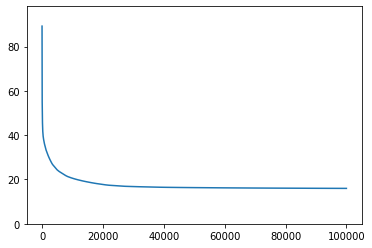

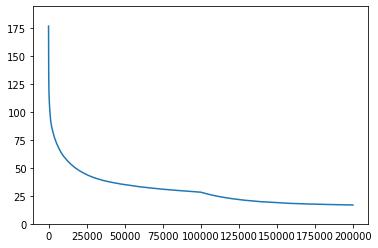

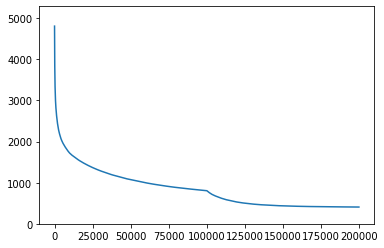

In [4]:
def plotLoss(loss):
    xs = np.arange(0, len(loss), 1)
    plt.plot(xs, loss)
    plt.ylim((0, loss[0]*1.1))
    plt.show()
    
plotLoss(loss1)
plotLoss(loss1a)
plotLoss(loss2a)

In [5]:
np.sum(it1 != 0), np.sum(it1a != 0), np.sum(it2a != 0)

(30384, 6153, 6922)

In [6]:
mhc1[0], it1

(array([0.      , 0.      , 0.      , ..., 0.999756, 0.99976 , 0.999829]),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.5665387e-05, 0.0000000e+00], dtype=float32))

In [7]:
def getCrit(xs, ys):
    inds = np.argwhere(ys != 0).reshape(-1)
    xs = xs[inds]
    ys = ys[inds]
    ys = np.cumsum(ys)
    ys = np.concatenate(([0], ys))
    return xs, ys

indcurve1 = getCrit(mhc1[0], it1)
indcurve1a = getCrit(mhc1a[0], it1a)
indcurve2a = getCrit(mhc2a[0], it2a)

In [8]:
with open("./isotonic_calibration.pkl", 'wb') as fout:
    pickle.dump((indcurve1a, indcurve2a), fout)

In [11]:
def getProb(key, indcurve):
    xs, ys = indcurve
    return ys[ np.searchsorted(xs, key, side='right') ]
    
getProb(np.linspace(0,1,100), indcurve1a), getProb(0.5, indcurve1), max(indcurve1a[1]),\
getProb(np.linspace(0,1,100), indcurve2a), getProb(0.5, indcurve1a), max(indcurve2a[1])

(array([0.        , 0.00564193, 0.00780005, 0.01186335, 0.01186335,
        0.01444388, 0.01778633, 0.02780532, 0.02780532, 0.02780532,
        0.02780532, 0.02780532, 0.02780532, 0.04050976, 0.04325285,
        0.04325285, 0.04325285, 0.04325285, 0.04325285, 0.04325285,
        0.04325285, 0.05800229, 0.05982868, 0.05982868, 0.05982868,
        0.05982868, 0.05982868, 0.05982868, 0.05982868, 0.05982868,
        0.05982868, 0.05982868, 0.05982868, 0.05982868, 0.08724393,
        0.08724393, 0.08724393, 0.08724393, 0.08724393, 0.08724393,
        0.109341  , 0.11023293, 0.11023293, 0.11023293, 0.11023293,
        0.11023293, 0.11023293, 0.11023293, 0.11023293, 0.11023293,
        0.11023293, 0.12753102, 0.12753102, 0.12753102, 0.12753102,
        0.12753102, 0.12753102, 0.12753102, 0.12753102, 0.12753102,
        0.18181579, 0.18181579, 0.18181579, 0.18181579, 0.18181579,
        0.19847786, 0.19847786, 0.19847786, 0.19847786, 0.19847786,
        0.19847786, 0.19847786, 0.19847786, 0.19

In [12]:
np.repeat(np.array([1,2,3]), 2)

array([1, 1, 2, 2, 3, 3])

In [13]:
def getBins(data, indcurve, windowSize, xlab, title):
    preds, targets, weights = data
    if indcurve != None:
        preds = getProb(preds, indcurve)
    
    weightw = np.convolve(weights, np.ones(windowSize), mode = "valid")
    targetw = np.convolve(targets * weights, np.ones(windowSize), mode = "valid")/weightw
    predw = np.convolve(preds * weights, np.ones(windowSize), mode = "valid")/weightw
    print (max(predw), max(targetw))
    _, ax = plt.subplots(1,1,figsize = (5,3))
    ax.plot(predw, targetw, color = "black", label="Calibration curve")
    ax.plot((0,1),(0,1),linestyle='--',zorder = -10, color = "grey", label="x=y")
    ax.set_xlim((0, max(predw)))
    ax.set_ylim((-0.1*max(max(targetw),max(predw)), 1.1*max(max(targetw),max(predw))))
    ax.set_xlabel(xlab)
    ax.set_ylabel("Fraction of positive samples")
    ax.set_title(title)
    ax.legend(loc = "upper left")
    plt.show()

0.996476870842322 0.9429007666542066


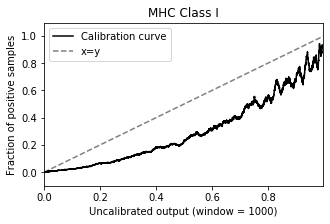

0.9760298927726206 0.47308110266826703


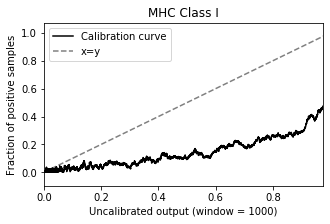

0.9635303684813852 0.4777607436631872


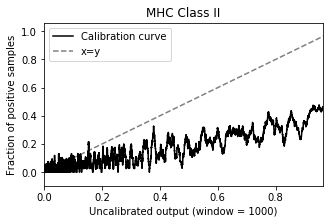

In [14]:
getBins(mhc1, None, 1000, "Uncalibrated output (window = 1000)", "MHC Class I")
getBins(mhc1a, None, 1000, "Uncalibrated output (window = 1000)", "MHC Class I")
getBins(mhc2a, None, 1000, "Uncalibrated output (window = 1000)", "MHC Class II")

0.9304865986711671 0.9429007666542066


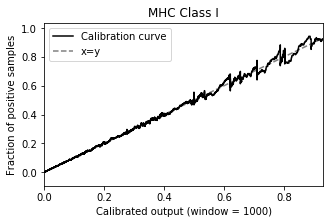

0.4745994658741209 0.47308110266826703


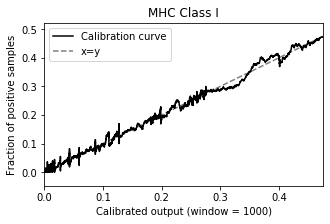

0.463749608322177 0.4777607436631872


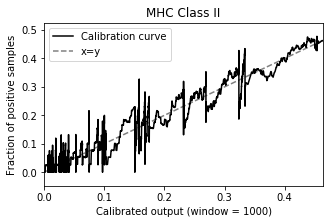

In [15]:
getBins(mhc1, indcurve1, 1000, "Calibrated output (window = 1000)", "MHC Class I")
getBins(mhc1a, indcurve1a, 1000, "Calibrated output (window = 1000)", "MHC Class I")
getBins(mhc2a, indcurve2a, 1000, "Calibrated output (window = 1000)", "MHC Class II")

0.8175943494270748 0.8144827650789386


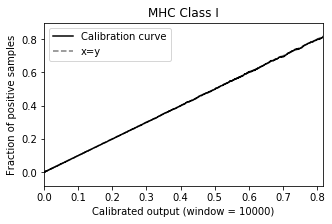

0.27286605193148955 0.27467014314096405


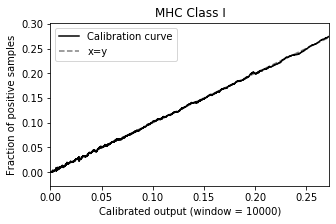

0.34112370288653504 0.34514789944755137


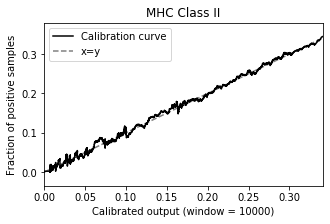

In [16]:
getBins(mhc1, indcurve1, 10000, "Calibrated output (window = 10000)", "MHC Class I")
getBins(mhc1a, indcurve1a, 10000, "Calibrated output (window = 10000)", "MHC Class I")
getBins(mhc2a, indcurve2a, 10000, "Calibrated output (window = 10000)", "MHC Class II")

In [19]:
indcurve1a, indcurve2a

((array([8.10000e-05, 3.63100e-03, 3.63100e-03, ..., 9.97194e-01,
         9.97373e-01, 9.97453e-01]),
  array([0.        , 0.0017957 , 0.0017957 , ..., 0.75719744, 0.77434093,
         0.78957981])),
 (array([5.75000e-04, 9.08200e-03, 9.08200e-03, ..., 9.23007e-01,
         9.88782e-01, 9.93585e-01]),
  array([0.        , 0.00697048, 0.00697048, ..., 0.45354673, 0.53938907,
         0.80520588])))